In [8]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 
import torch


data = pd.read_parquet('clean_data.parquet')
data_dir = Path("data")

In [2]:
import json
import h5py
import numpy as np

def load_recording(path_to_h5):
    """
    Returns: 
        eeg data: np.array of type np.float32 with shape (4, X)"
        metadata: dict
    """
    with h5py.File(path_to_h5, "r") as f:
        assert list(f.keys()) == ['eeg4_datasetName'], f"expected structure to be ['eeg4_datasetName'], got {f.keys()}"
        data = f['eeg4_datasetName']
        data_dtype = np.dtype([('timestamp_name', '<u4'), ('eeg1_name', '<f4'), ('eeg2_name', '<f4'), ('eeg3_name', '<f4'), ('eeg4_name', '<f4')])
        assert data.dtype == data_dtype, f"expected dtype to be {data_dtype}, got {data.dtype}"
        # assert (data['timestamp_name'] == np.arange(data.shape[0]) * 4).all(), f"expected timestamp_name to be 0, 4, 8 ... (len(data) - 1) * 4, but got {data['timestamp_name'][:5]}... failed in {(1 * ~(data['timestamp_name'] == np.arange(data.shape[0]) * 4)).sum()} / {data.shape[0]} positions"
        timestamps = data['timestamp_name'] 
        final_data = np.vstack([data['eeg1_name'], data['eeg2_name'], data['eeg3_name'], data['eeg4_name']])
        
        meta = dict(f['eeg4_datasetName'].attrs.items())
        assert list(meta.keys()) == ['eeg4_datasetAttribute', 'eeg4_datasetAttributeStartTime'], f"expected metadata to have keys ['eeg4_datasetAttribute', 'eeg4_datasetAttributeStartTime'], got {meta.keys()}"
        meta['eeg4_datasetAttribute'] = json.loads(meta['eeg4_datasetAttribute'])
        assert meta['eeg4_datasetAttribute']['channelCount'] == 4, f"expected data to have 4 channels. got {meta['eeg4_datasetAttribute']['channelCount']}"
        
        return final_data, timestamps, meta
    
def validate_recording(path_to_h5):
    with h5py.File(path_to_h5, "r") as f:
        assert list(f.keys()) == ['eeg4_datasetName'], f"expected structure to be ['eeg4_datasetName'], got {f.keys()}"
    
        
d, time, _ = load_recording('data/link-0000e8c5-3901-4e02-803f-56313c20b5d0--be88335f-f2d4-437a-bd1a-01f93fa7bd6f_1706884833549_session_eeg.h5')

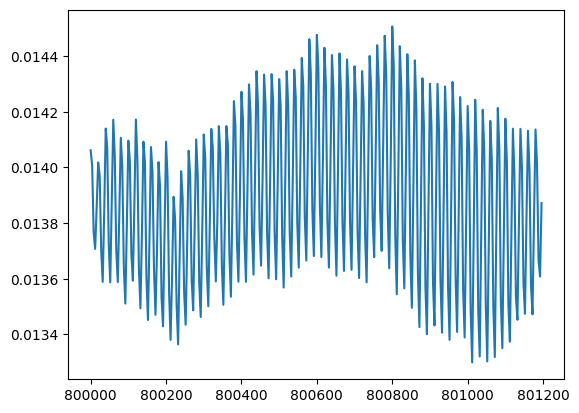

In [3]:
import matplotlib.pyplot as plt

plt.plot(time[200000:200300], d[3, 200000:200300])

In [6]:
t = np.arange(10).reshape(2, 5)
np.cumsum(t, axis=1)

array([[ 0,  1,  3,  6, 10],
       [ 5, 11, 18, 26, 35]])

In [16]:
def calc_running_mean(arr, n):
    assert len(arr.shape) == 2, 'expects 2d array (channels, time)'
    res = np.cumsum(arr, axis=1) 
    res[:, n:] = (res[:, n:] - res[:, :-n]) / n
    res[:, :n] = res[:, :n] / (np.arange(n) + 1).reshape(1, -1)
    return res

calc_running_mean(np.array([
    [1.0, 2, 3, 4, 5, 6],
    [1.0, 2, 3, 4, 5, 6]]), 3)

array([[1. , 1.5, 2. , 3. , 4. , 5. ],
       [1. , 1.5, 2. , 3. , 4. , 5. ]])

In [8]:
mean_d = calc_running_mean(d, 250)
diff_abs = abs(d - mean_d)

<Axes: >

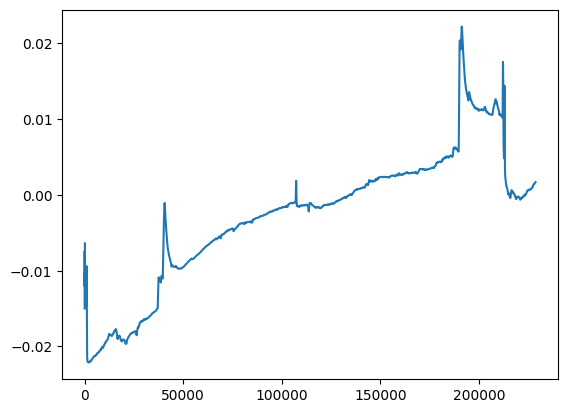

In [9]:
pd.Series(mean_d[2, :]).plot()

In [10]:
import pandas as pd

diff_from_mean = diff_abs
print(pd.Series(diff_abs[0]).describe())
print((diff_from_mean < 0.001).mean())

count    228736.000000
mean          0.000861
std           0.003574
min           0.000000
25%           0.000349
50%           0.000711
75%           0.001039
max           0.172106
dtype: float64
0.8779870680609961


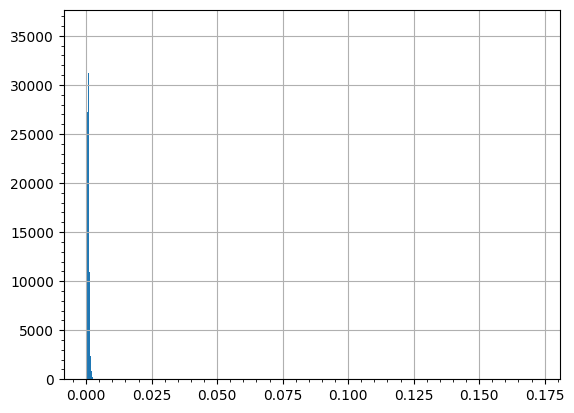

In [11]:
plt.hist(diff_abs[0], bins=1000)
plt.gca().grid(True)
plt.gca().minorticks_on()

(0.0, 0.02)

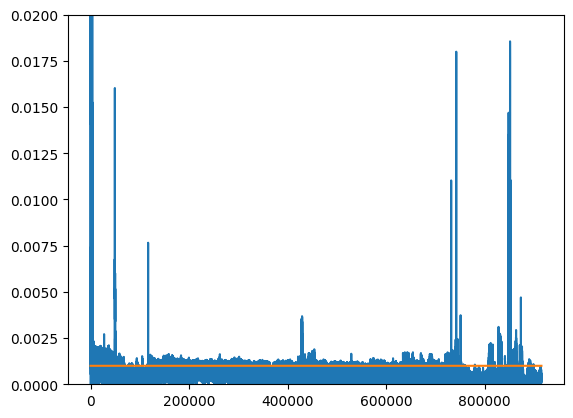

In [12]:
import matplotlib.pyplot as plt

plt.plot(time, diff_abs[0])
plt.plot(time, [0.001] * len(time))
ax = plt.gca()
ax.set_ylim([0, 0.02])

In [13]:
sample_files = ['data/' + x for x in data['filename_h5'][:10].tolist()]
res = []
for el in sample_files:
    res.append(load_recording(el))

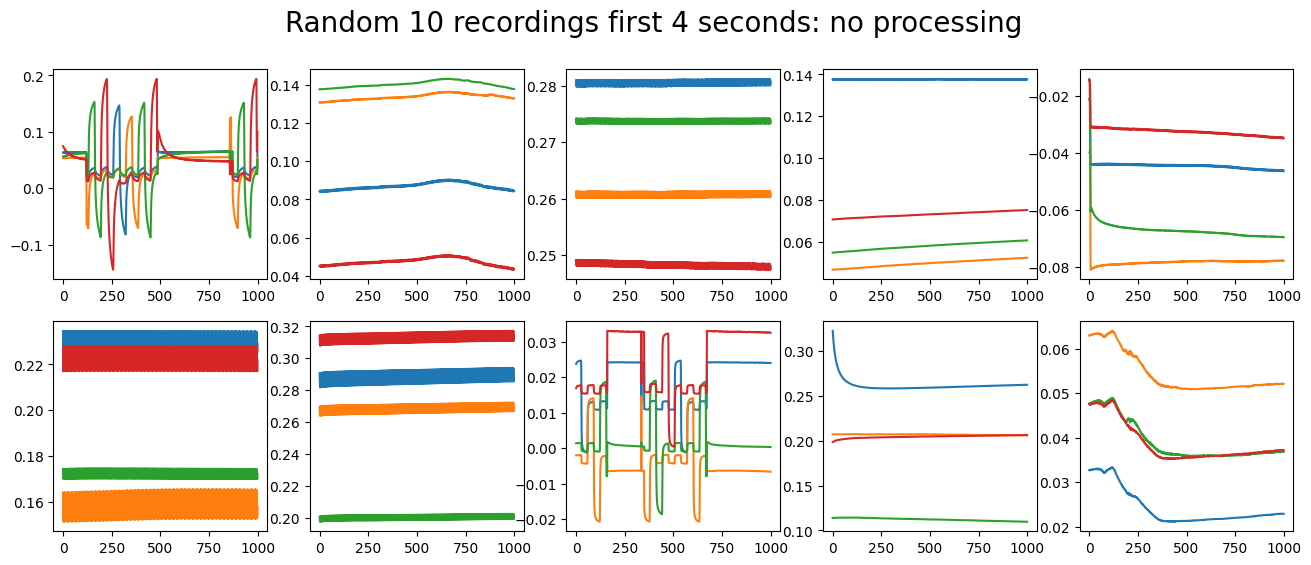

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,6))

fig.suptitle('Random 10 recordings first 4 seconds: no processing', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    for i in range(4):
        ax.plot(np.arange(1000), s[i, :1000])

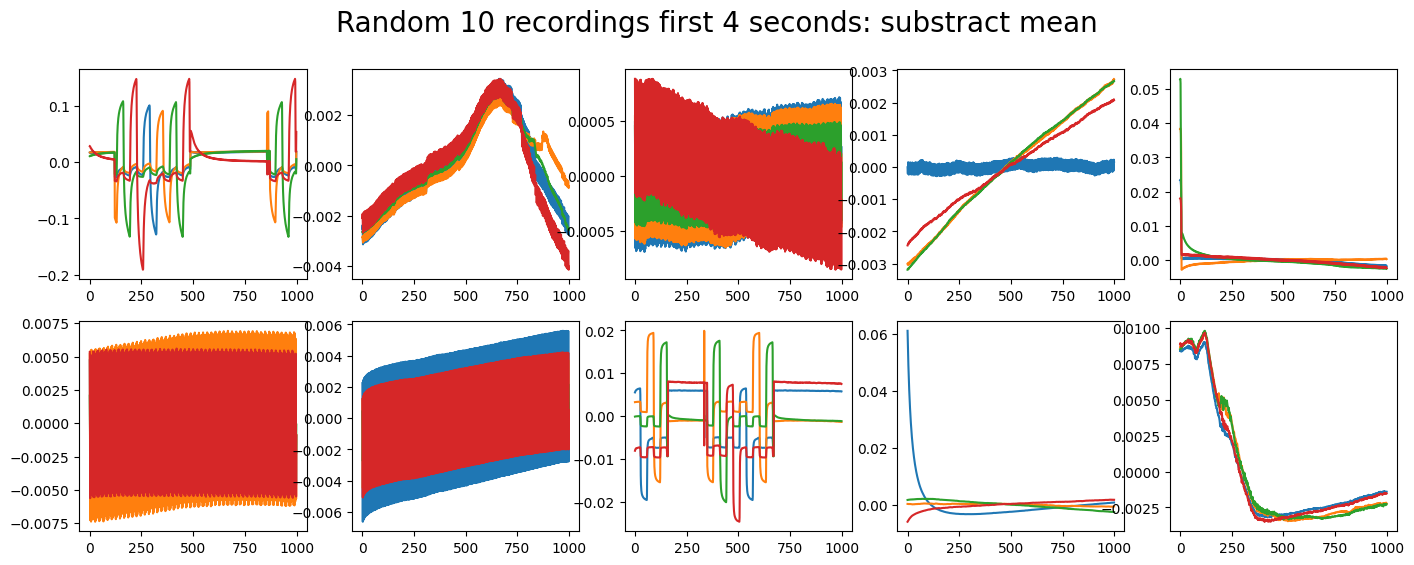

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Random 10 recordings first 4 seconds: substract mean', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    s = s - s[:, :1000].mean(axis=1, keepdims=True)
    for i in range(4):
        ax.plot(np.arange(1000), s[i, :1000])

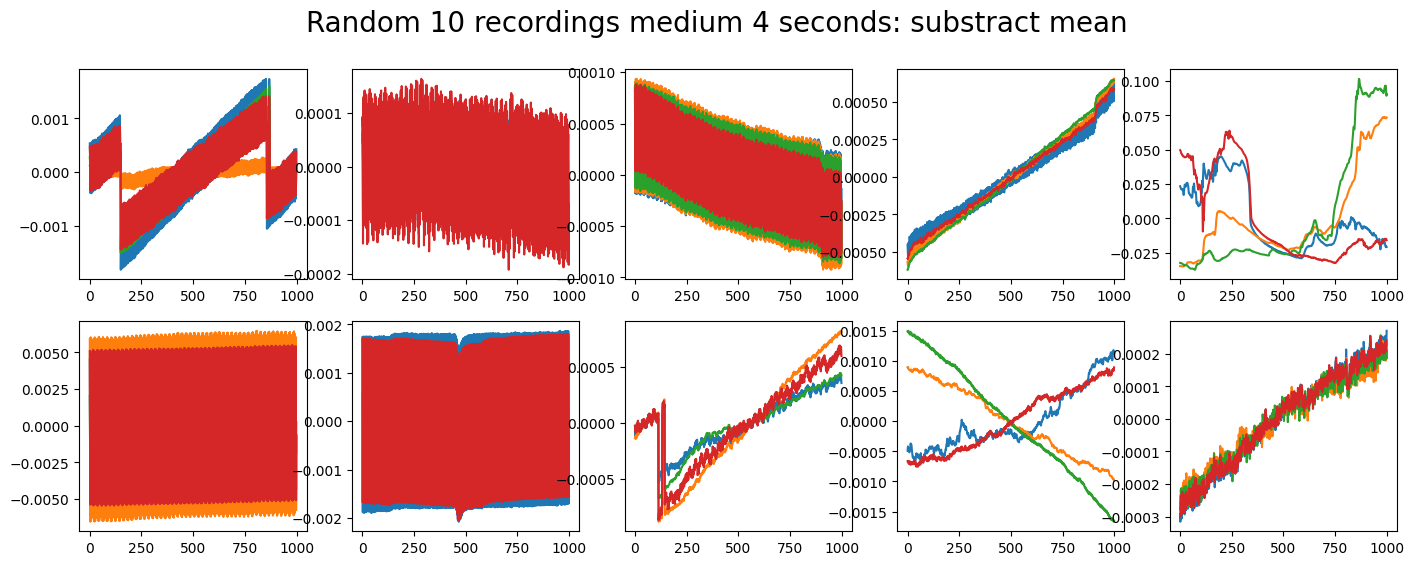

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Random 10 recordings medium 4 seconds: substract mean', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    time_dim = s.shape[1]
    med = time_dim // 2
    for i in range(4):
        q = s[i, med - 500: med + 500]
        q = q - q.mean()
        ax.plot(np.arange(1000), q)

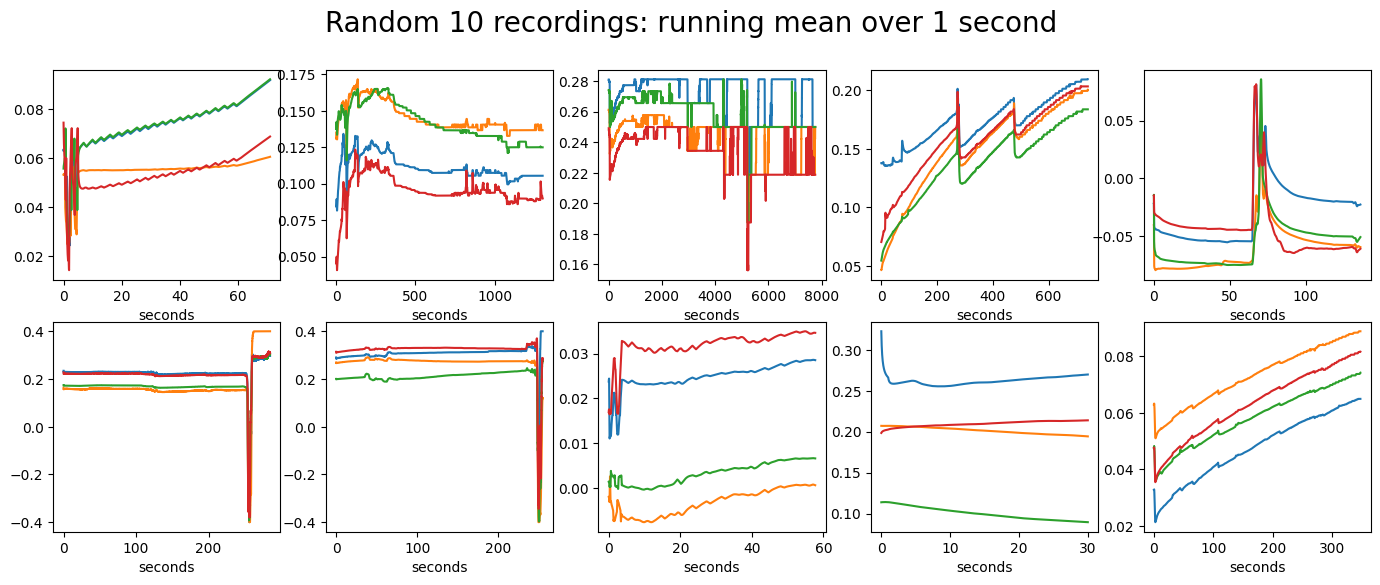

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Random 10 recordings: running mean over 1 second', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    running_mean = calc_running_mean(s, 250)
    for i in range(4):
        ax.plot(np.arange(running_mean.shape[1]) / 250, running_mean[i, :])
        ax.set_xlabel('seconds')

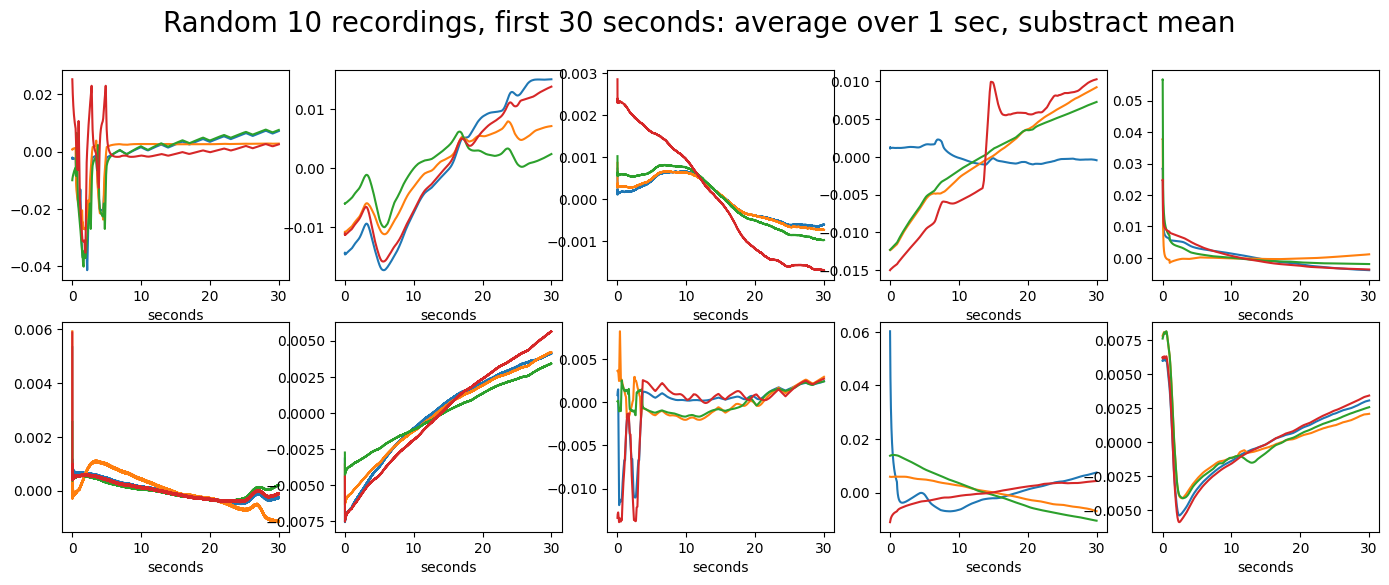

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Random 10 recordings, first 30 seconds: average over 1 sec, substract mean', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    running_mean = calc_running_mean(s, 250)
    running_mean = running_mean[:, :250 * 30]
    running_mean = running_mean - running_mean.mean(axis = 1, keepdims=True)
    for i in range(4):
        ax.plot(np.arange(running_mean.shape[1]) / 250, running_mean[i, :])
        ax.set_xlabel('seconds')

In [11]:
# from scipy.signal import ShortTimeFFT

# time = np.arange(250) # lets assume 1 hz
# signal = np.sin(time / 10)

# SFT = ShortTimeFFT(250, hop=125, fs=250)
# Sx = SFT.stft(signal)  # perform the STFT

from torch import stft
import torch

time = torch.arange(1000)
signal = torch.sin(time)

stft(signal, n_fft=100, window=torch.hann_window(100), hop_length=50, return_complex=False).shape


/home/ubuntu/.local/lib/python3.10/site-packages/torch/functional.py:665: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


torch.Size([51, 21, 2])

Text(0.5, 1.0, 'Random recording, first 30s')

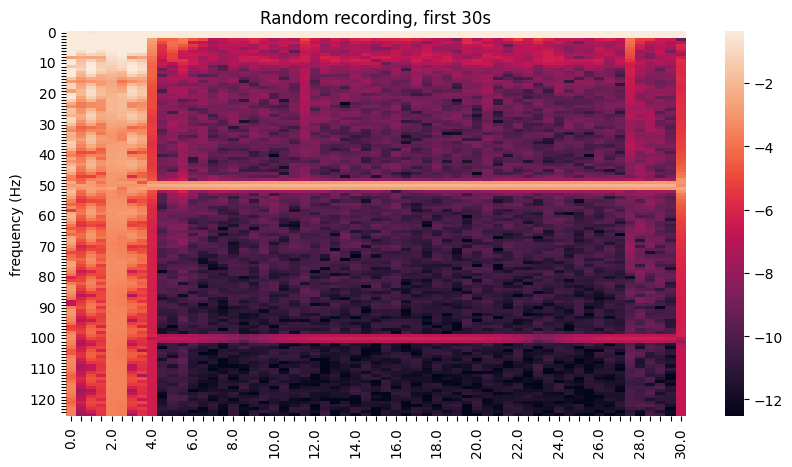

In [89]:
import seaborn as sns 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

tnsr = torch.tensor(d)[0, : 250 * 30]

spec = stft(tnsr, n_fft=250, window=torch.hann_window(250), hop_length=125, return_complex=False)
spec = torch.sqrt((spec * spec).sum(2))


ax = sns.heatmap(torch.log(spec), robust=True, yticklabels=np.arange(125), xticklabels=np.linspace(0, 30, num=spec.shape[1]))
for ind, label in enumerate(ax.yaxis.get_ticklabels()):
    if ind % 10 != 0:
        label.set_visible(False)
for ind, label in enumerate(ax.xaxis.get_ticklabels()):
    if ind % 4 != 0:
        label.set_visible(False)
ax.set_ylabel("frequency (Hz)")
ax.set_title('Random recording, first 30s')

<Axes: >

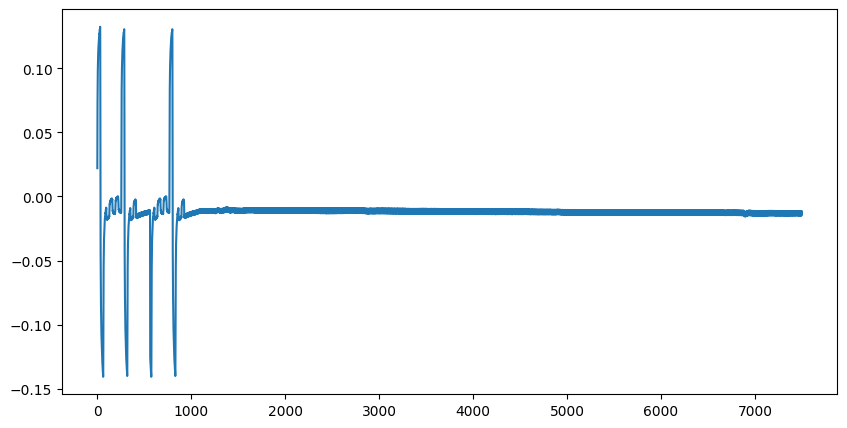

In [88]:
pd.Series(tnsr).plot()

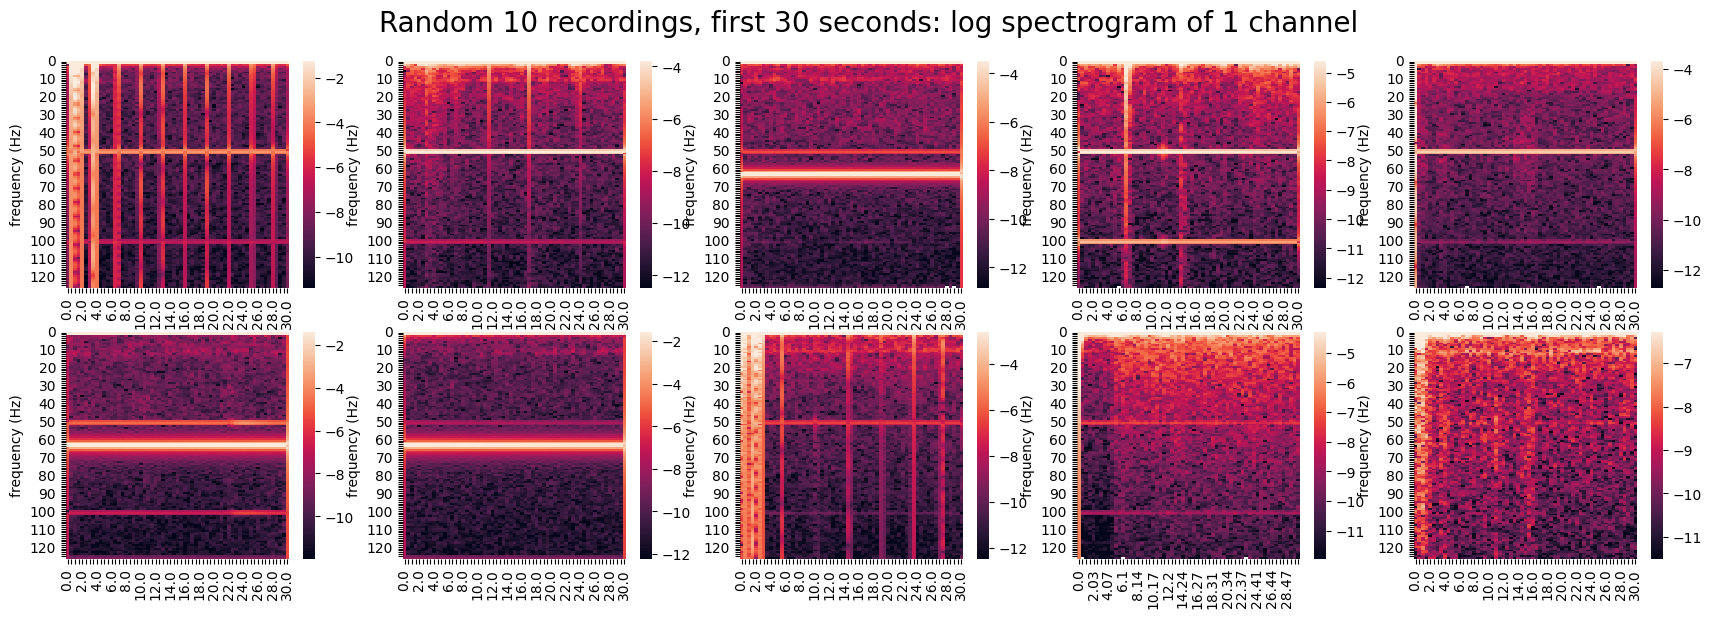

In [96]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))
fig.suptitle('Random 10 recordings, first 30 seconds: log spectrogram of 1 channel', fontsize=20)
fig.tight_layout()

for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    tnsr = torch.tensor(s[0, :250 * 30])

    spec = stft(tnsr, n_fft=250, window=torch.hann_window(250), hop_length=125, return_complex=False)
    spec = torch.sqrt((spec * spec).sum(2))


    sns.heatmap(torch.log(spec), robust=True, yticklabels=np.arange(125), xticklabels=np.round(np.linspace(0, 30, num=spec.shape[1]), 2), ax=ax)
    for ind, label in enumerate(ax.yaxis.get_ticklabels()):
        if ind % 10 != 0:
            label.set_visible(False)
    for ind, label in enumerate(ax.xaxis.get_ticklabels()):
        if ind % 4 != 0:
            label.set_visible(False)
    ax.set_ylabel("frequency (Hz)")

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Random 10 recordings, first 30 seconds: average over 1 sec, substract mean', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    running_mean = calc_running_mean(s, 250)
    running_mean = running_mean[:, :250 * 30]
    running_mean = running_mean - running_mean.mean(axis = 1, keepdims=True)
    for i in range(4):
        ax.plot(np.arange(running_mean.shape[1]) / 250, running_mean[i, :])
        ax.set_xlabel('seconds')

In [13]:
import seaborn as sns

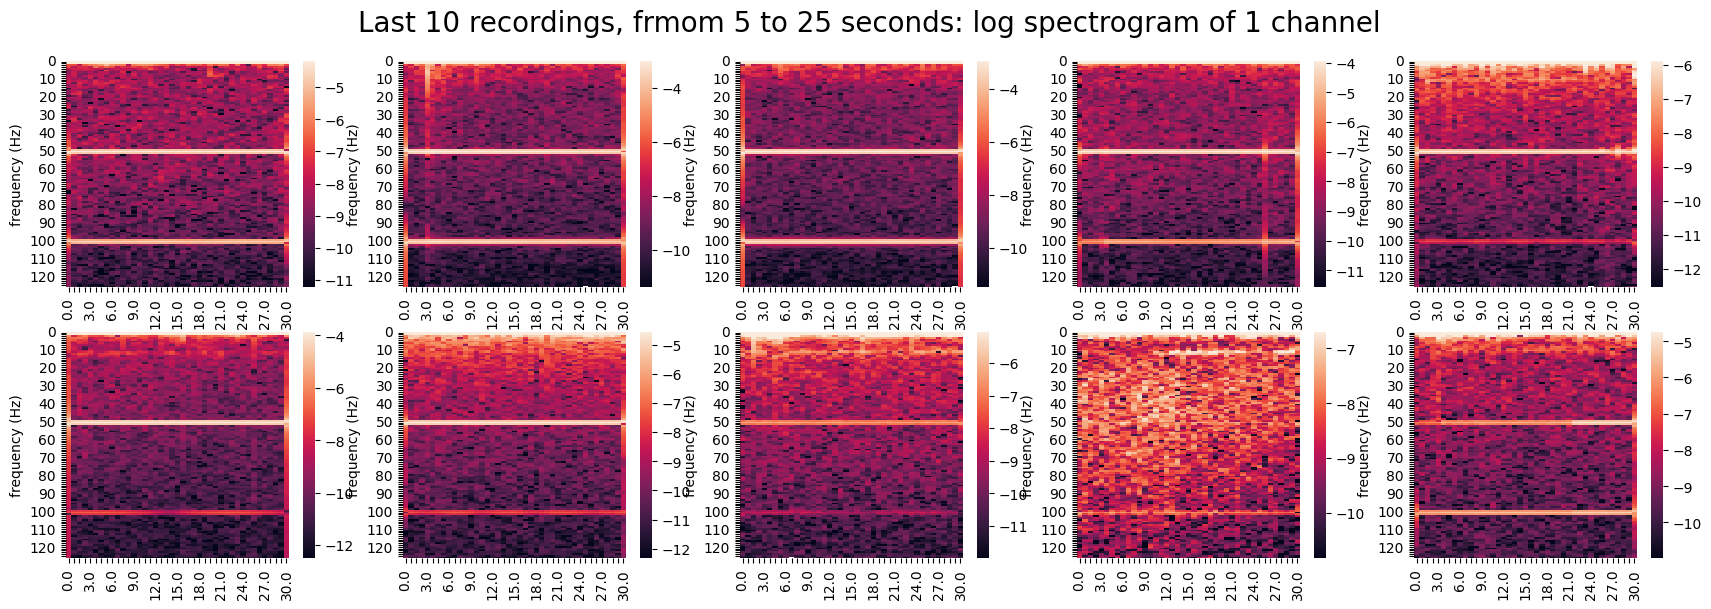

In [22]:
sample_files = ['data/' + x for x in data.sort_values(by='time_start', ascending=False)[:10]['filename_h5'][:10].tolist()]
res = []
for el in sample_files:
    res.append(load_recording(el))
    
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))
fig.suptitle('Last 10 recordings, frmom 5 to 25 seconds: log spectrogram of 1 channel', fontsize=20)
fig.tight_layout()

for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    tnsr = torch.tensor(s[0, 250 * 5 : 250 * 25])

    spec = stft(tnsr, n_fft=250, window=torch.hann_window(250), hop_length=125, return_complex=False)
    spec = torch.sqrt((spec * spec).sum(2))


    sns.heatmap(torch.log(spec), robust=True, yticklabels=np.arange(125), xticklabels=np.round(np.linspace(0, 30, num=spec.shape[1]), 2), ax=ax)
    for ind, label in enumerate(ax.yaxis.get_ticklabels()):
        if ind % 10 != 0:
            label.set_visible(False)
    for ind, label in enumerate(ax.xaxis.get_ticklabels()):
        if ind % 4 != 0:
            label.set_visible(False)
    ax.set_ylabel("frequency (Hz)")

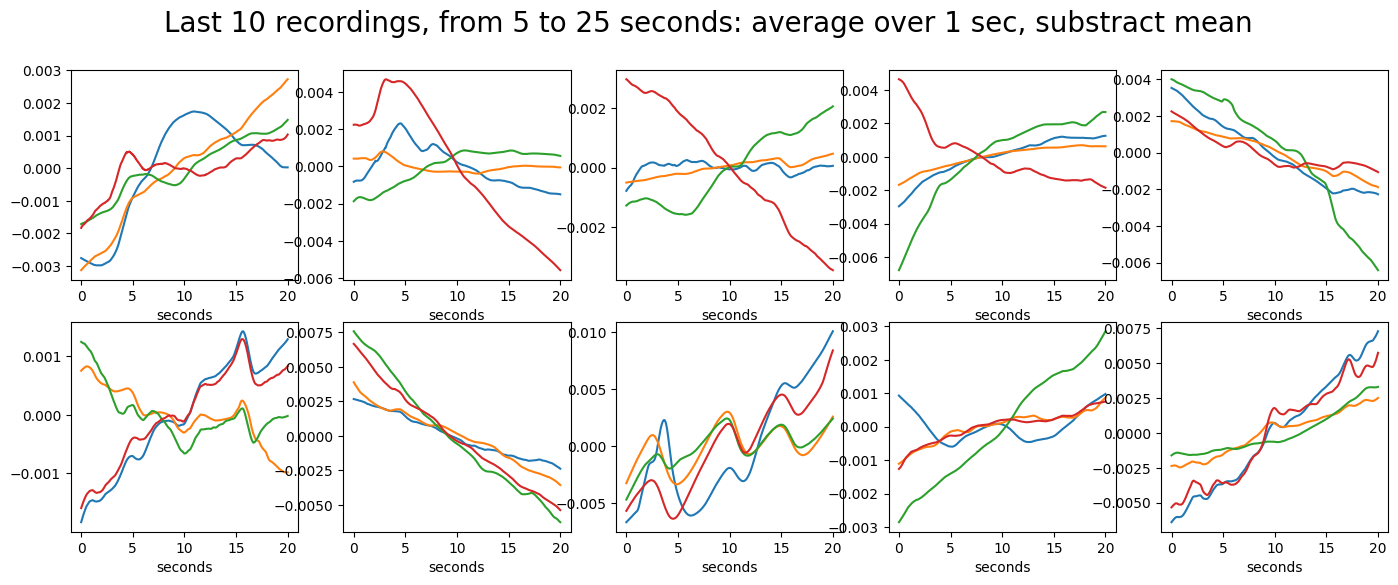

In [21]:
sample_files = ['data/' + x for x in data.sort_values(by='time_start', ascending=False)[:10]['filename_h5'][:10].tolist()]
res = []
for el in sample_files:
    res.append(load_recording(el))
    
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Last 10 recordings, from 5 to 25 seconds: average over 1 sec, substract mean', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    running_mean = calc_running_mean(s, 250)
    running_mean = running_mean[:, 250 * 5 :250 * 25]
    running_mean = running_mean - running_mean.mean(axis = 1, keepdims=True)
    for i in range(4):
        ax.plot(np.arange(running_mean.shape[1]) / 250, running_mean[i, :])
        ax.set_xlabel('seconds')

In [ ]:
sample_files = ['data/' + x for x in data.sort_values(by='time_start', ascending=False)[:10]['filename_h5'][:10].tolist()]
res = []
for el in sample_files:
    res.append(load_recording(el))
    
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17,6))

fig.suptitle('Last 10 recordings, from 5 to 25 seconds: average over 1 sec, substract mean', fontsize=20)
for ind, ax in enumerate(axs.flatten()):
    s = res[ind][0]
    s = s[:, 250 * 5 :250 * 25]
    s
    # running_mean = calc_running_mean(s, 250)
    # running_mean = running_mean[:, 250 * 5 :250 * 25]
    running_mean = running_mean - running_mean.mean(axis = 1, keepdims=True)
    for i in range(4):
        ax.plot(np.arange(running_mean.shape[1]) / 250, running_mean[i, :])
        ax.set_xlabel('seconds')

In [39]:
s = torch.tensor(res[0][0])
s = s[:, 250 * 5 :250 * 25]
s = s - s.mean(1, keepdim=True)
s = s - s.mean(0, keepdim=True)

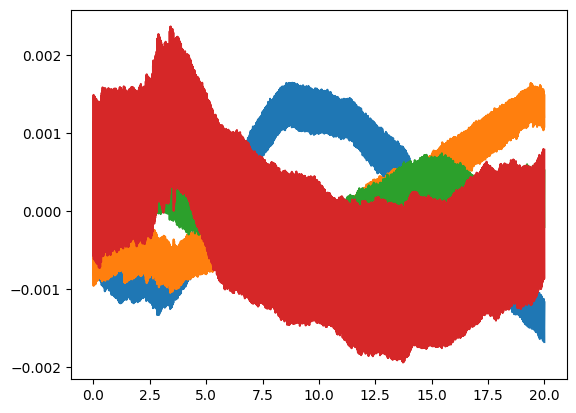

In [40]:
for i in range(4):
    plt.plot(np.arange(s.shape[1]) / 250, s[i, :])

In [67]:
from scipy import signal

def do_notch(x, notch_f, sr=250, q=1.0):
    b_notch, a_notch = signal.iirnotch(notch_f, 100.0, 250)
    return signal.filtfilt(b_notch, a_notch, x)


s_org = s[0, :].numpy()
s_filt = do_notch(s_org, 50)
s_filt = do_notch(s_filt, 100)

<Axes: >

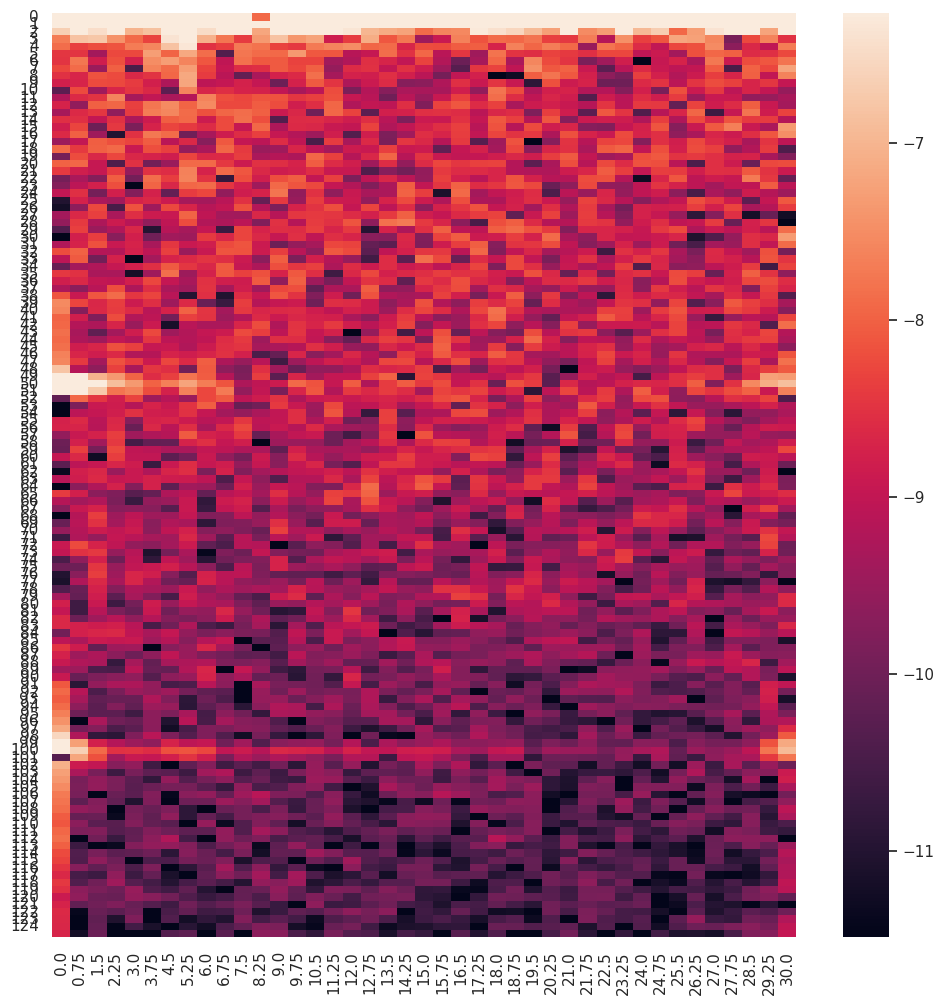

In [68]:
sns.set_theme(rc={'figure.figsize':(12,12)})

spec = stft(torch.tensor(s_filt.copy()), n_fft=250, window=torch.hann_window(250), hop_length=125, return_complex=False)
spec = torch.sqrt((spec * spec).sum(2))

sns.heatmap(torch.log(spec), robust=True, yticklabels=np.arange(125), xticklabels=np.round(np.linspace(0, 30, num=spec.shape[1]), 2))

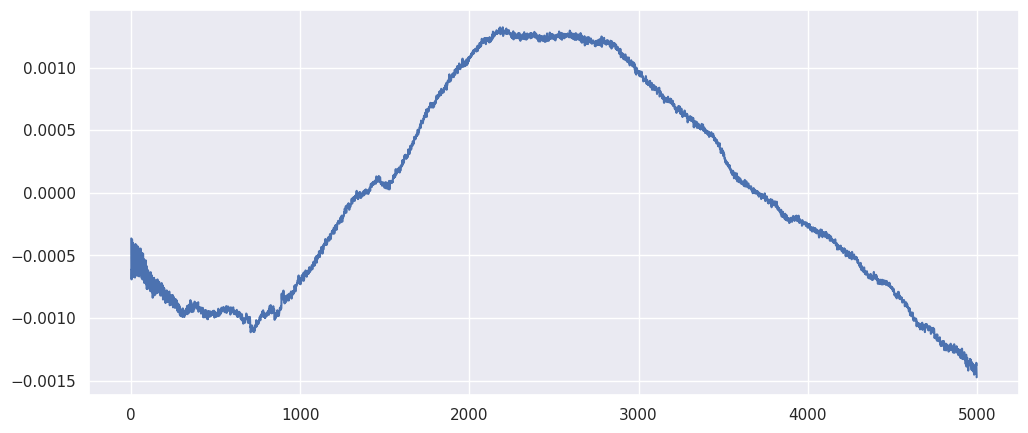

In [77]:
plt.plot(np.arange(s_filt.shape[0]), s_filt)

array([[ 0.00000000e+00, -6.58652232e-05, -1.74022874e-04, ...,
        -1.45449025e-05, -7.25353142e-05, -1.26659366e-04]])

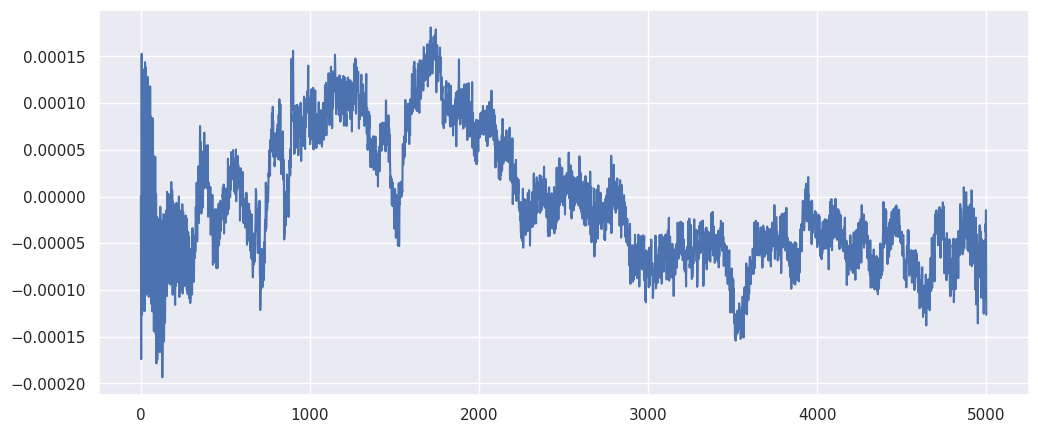

In [74]:
sns.set_theme(rc={'figure.figsize':(12, 5)})
plt.plot(np.arange(s_filt.shape[0]), (s_filt - calc_running_mean(s_filt[np.newaxis], 100))[0, :])

(array([  1.,   0.,   0.,   1.,   1.,   1.,   0.,   2.,   1.,   0.,   6.,
          5.,   6.,   9.,  11.,  13.,   9.,  15.,  16.,  16.,  16.,  12.,
         29.,  37.,  21.,  45.,  47.,  61.,  70.,  91.,  90., 117., 105.,
        121., 127., 138., 163., 141., 160., 141., 151., 130., 124., 104.,
        127., 109., 110., 117., 116.,  96.,  88.,  62.,  98.,  69.,  65.,
         55.,  38.,  41.,  47.,  29.,  38.,  39.,  38.,  36.,  48.,  40.,
         49.,  42.,  53.,  50.,  42.,  68.,  62.,  53.,  59.,  66.,  66.,
         61.,  51.,  57.,  39.,  45.,  42.,  29.,  30.,  37.,  19.,  17.,
         23.,  14.,  22.,  11.,   4.,   8.,  10.,   4.,   1.,   3.,   0.,
          3.]),
 array([-1.93554212e-04, -1.89806636e-04, -1.86059060e-04, -1.82311484e-04,
        -1.78563908e-04, -1.74816332e-04, -1.71068756e-04, -1.67321180e-04,
        -1.63573605e-04, -1.59826029e-04, -1.56078453e-04, -1.52330877e-04,
        -1.48583301e-04, -1.44835725e-04, -1.41088149e-04, -1.37340573e-04,
        -1.335

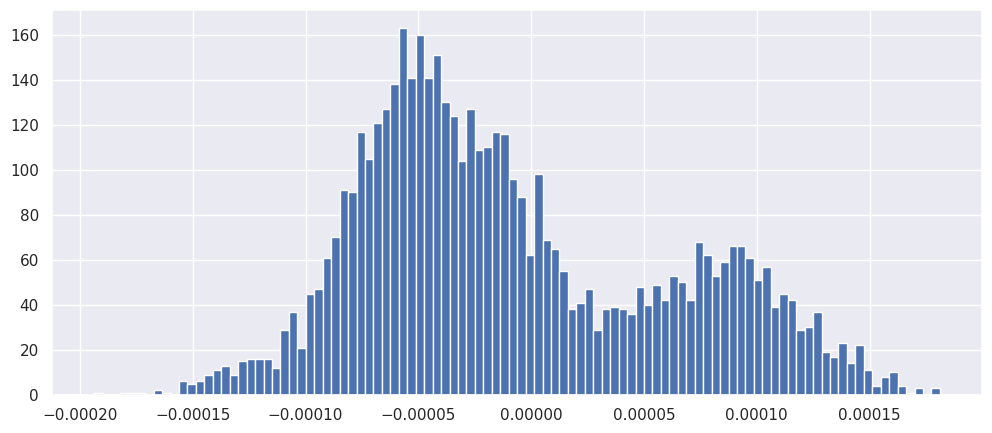

In [76]:
plt.hist((s_filt - calc_running_mean(s_filt[np.newaxis], 100))[0, :], bins=100)

In [52]:
sns.set_theme(rc={'figure.figsize':(12,12)})s_filt

array([-0.00033677, -0.00052744, -0.0007003 , ..., -0.00137698,
       -0.00133402, -0.00158375])

In [83]:
data_try = data[(data['duration'] > 3600) & (data['duration'] < 2 * 3600)]
data_try = data_try.sort_values(by='time_start', ascending=False)[:500]

In [86]:
data_try.to_parquet('data/metadata.parquet')

In [2]:
batch = s.unsqueeze(0).tile((3, 1, 1))
batch.shape

NameError: name 's' is not defined

In [3]:
batch

NameError: name 'batch' is not defined